Comparison of Methods:
NAIVE: Time = 0.0002s, Memory = 16240 bytes
KD_TREE: Time = 0.0015s, Memory = 16240 bytes


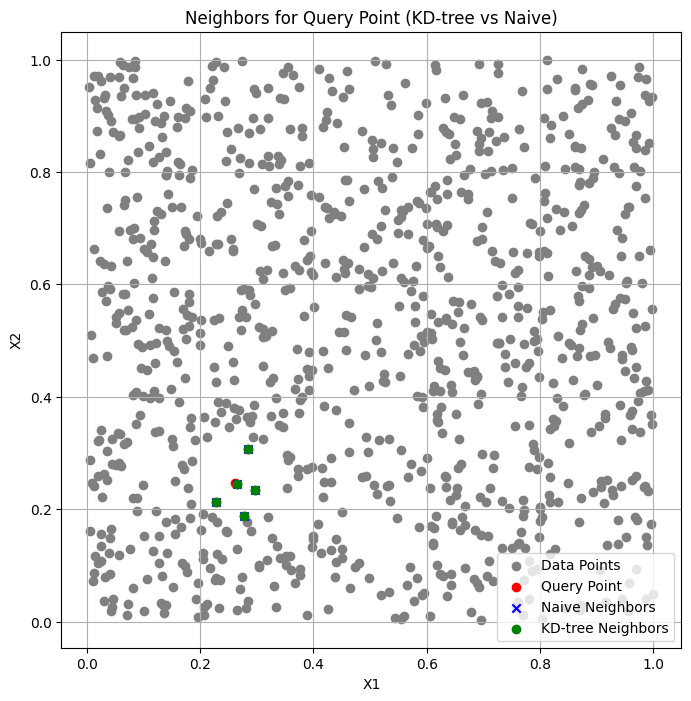

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances_argmin_min
import time
import sys

# Generate synthetic data
def generate_data(N, D, random_state=42):
    np.random.seed(random_state)
    return np.random.rand(N, D)

# Naive KNN
def naive_knn(train_data, query_point, k):
    distances = np.linalg.norm(train_data - query_point, axis=1)
    nearest_indices = np.argsort(distances)[:k]
    return nearest_indices

# KD-tree KNN
def kd_tree_knn(train_data, query_point, k):
    kd_tree = KDTree(train_data)
    dist, ind = kd_tree.query(query_point.reshape(1, -1), k=k)
    return ind[0]

# Visualization helper: plot 2D points and missed neighbors
def plot_2d_neighbors(train_data, query_point, naive_neighbors, approx_neighbors, method_name):
    plt.figure(figsize=(8, 8))
    plt.scatter(train_data[:, 0], train_data[:, 1], c='gray', label='Data Points')
    plt.scatter(query_point[0], query_point[1], c='red', label='Query Point')

    # Plot naive neighbors
    plt.scatter(train_data[naive_neighbors, 0], train_data[naive_neighbors, 1], c='blue', label='Naive Neighbors', marker='x')

    # Plot approximate neighbors
    plt.scatter(train_data[approx_neighbors, 0], train_data[approx_neighbors, 1], c='green', label=f'{method_name} Neighbors', marker='o')

    # Highlight missed neighbors
    missed = set(naive_neighbors) - set(approx_neighbors)
    if missed:
        missed_points = train_data[list(missed)]
        plt.scatter(missed_points[:, 0], missed_points[:, 1], c='orange', label='Missed Neighbors', marker='s')

    plt.legend()
    plt.title(f"Neighbors for Query Point ({method_name} vs Naive)")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.show()

# Comparison helper: time and memory
def compare_methods(N, D, k):
    train_data = generate_data(N, D)
    query_point = np.random.rand(D)

    results = {}

    # Naive KNN
    start = time.time()
    naive_neighbors = naive_knn(train_data, query_point, k)
    naive_time = time.time() - start
    naive_memory = sys.getsizeof(train_data) + sys.getsizeof(naive_neighbors)
    results['naive'] = (naive_time, naive_memory)

    # KD-tree KNN
    start = time.time()
    kd_neighbors = kd_tree_knn(train_data, query_point, k)
    kd_time = time.time() - start
    kd_memory = sys.getsizeof(train_data) + sys.getsizeof(kd_neighbors)  # Approximation
    results['kd_tree'] = (kd_time, kd_memory)

    return results, naive_neighbors, kd_neighbors, train_data, query_point

# Parameters
N, D, k = 1000, 2, 5
results, naive_neighbors, kd_neighbors, train_data, query_point = compare_methods(N, D, k)

# Print results
print("Comparison of Methods:")
for method, (time_taken, memory_used) in results.items():
    print(f"{method.upper()}: Time = {time_taken:.4f}s, Memory = {memory_used} bytes")

# Visualization
plot_2d_neighbors(train_data, query_point, naive_neighbors, kd_neighbors, method_name="KD-tree")


Extended Comparison of Methods:
NAIVE: Time = 0.0003s, Memory = 16240 bytes
KD_TREE: Time = 0.0013s, Memory = 16240 bytes
LSH: Time = 0.1101s, Memory = 16244 bytes


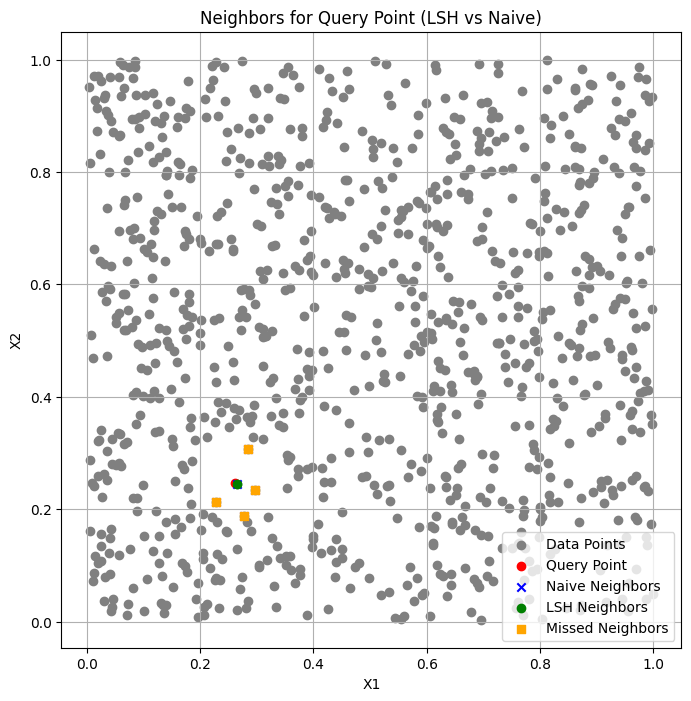

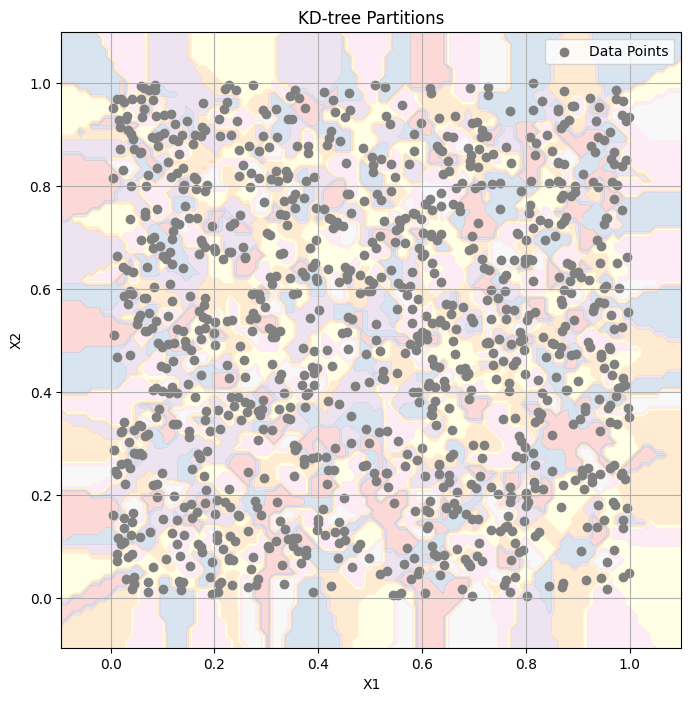

In [2]:
from sklearn.neighbors import NearestNeighbors

# LSH implementation using random hyperplanes
class LSHKNN:
    def __init__(self, n_planes=10, random_state=42):
        np.random.seed(random_state)
        self.n_planes = n_planes
        self.planes = None
        self.hash_table = {}

    def fit(self, data):
        self.data = data
        D = data.shape[1]
        self.planes = np.random.randn(self.n_planes, D)

        # Hashing data points
        hashes = self._hash(data)
        for i, h in enumerate(hashes):
            self.hash_table.setdefault(tuple(h), []).append(i)

    def query(self, query_point, k):
        query_hash = self._hash(query_point.reshape(1, -1))[0]
        candidate_indices = set()

        # Gather candidates from hash table
        for h in self.hash_table:
            if sum(np.array(h) == query_hash) >= self.n_planes // 2:  # Similar hashes
                candidate_indices.update(self.hash_table[h])

        # Compute distances only for candidates
        candidates = self.data[list(candidate_indices)]
        nearest_indices, _ = pairwise_distances_argmin_min(query_point.reshape(1, -1), candidates)
        nearest_indices = nearest_indices[:k]
        return [list(candidate_indices)[i] for i in nearest_indices]

    def _hash(self, data):
        return (np.dot(data, self.planes.T) > 0).astype(int)

# LSH KNN wrapper
def lsh_knn(train_data, query_point, k, n_planes=10):
    lsh_knn_model = LSHKNN(n_planes=n_planes)
    lsh_knn_model.fit(train_data)
    return lsh_knn_model.query(query_point, k)

# Extended comparison with LSH
def extended_comparison(N, D, k, n_planes=10):
    train_data = generate_data(N, D)
    query_point = np.random.rand(D)

    results = {}

    # Naive KNN
    start = time.time()
    naive_neighbors = naive_knn(train_data, query_point, k)
    naive_time = time.time() - start
    naive_memory = sys.getsizeof(train_data) + sys.getsizeof(naive_neighbors)
    results['naive'] = (naive_time, naive_memory)

    # KD-tree KNN
    start = time.time()
    kd_neighbors = kd_tree_knn(train_data, query_point, k)
    kd_time = time.time() - start
    kd_memory = sys.getsizeof(train_data) + sys.getsizeof(kd_neighbors)
    results['kd_tree'] = (kd_time, kd_memory)

    # LSH KNN
    start = time.time()
    lsh_neighbors = lsh_knn(train_data, query_point, k, n_planes)
    lsh_time = time.time() - start
    lsh_memory = sys.getsizeof(train_data) + sys.getsizeof(lsh_neighbors) + sys.getsizeof(n_planes)
    results['lsh'] = (lsh_time, lsh_memory)

    return results, naive_neighbors, kd_neighbors, lsh_neighbors, train_data, query_point

# Parameters
N, D, k, n_planes = 1000, 2, 5, 10
results, naive_neighbors, kd_neighbors, lsh_neighbors, train_data, query_point = extended_comparison(N, D, k, n_planes)

# Print results
print("Extended Comparison of Methods:")
for method, (time_taken, memory_used) in results.items():
    print(f"{method.upper()}: Time = {time_taken:.4f}s, Memory = {memory_used} bytes")

# Visualization for LSH
plot_2d_neighbors(train_data, query_point, naive_neighbors, lsh_neighbors, method_name="LSH")

# Partition visualization (KD-tree)
def visualize_partitions_kd_tree(data, k):
    kd_tree = KDTree(data)
    x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
    y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Query KD-tree for each grid point
    _, regions = kd_tree.query(mesh_points, k=1)
    regions = regions.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, regions, alpha=0.5, cmap='Pastel1')
    plt.scatter(data[:, 0], data[:, 1], c='gray', label='Data Points')
    plt.title("KD-tree Partitions")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid()
    plt.show()

visualize_partitions_kd_tree(train_data, k)
